# ACS2 in Multiplexer

In [1]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + custom environments
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
sys.path.append("/Users/khozzy/Projects/openai-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration

# Load environments
import gym
import gym_multiplexer

## Multiplexer

In [2]:
mp = gym.make('boolean-multiplexer-6bit-v0')
situation = mp.reset()
mp.render()

'0011100'

In [3]:
state, reward, done, _ = mp.step(0)

print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

New state: 0011100, reward: 0, is done: True


In [4]:
mp.render()

'0011100'

### Evaluation
Calculate knowledge - check if any of the reliable classifiers gives correct answer.

In [5]:
from gym_multiplexer.utils import get_correct_answer

def evaluate_performance(env, population, ctrl_bits):
    p1 = env.render()  # state after executing action
    p0 = p1[:-1] + '0'  # initial state
    true_action = get_correct_answer(p0, ctrl_bits)
    
    # get all classifiers matching initial state
    matching_cls = {c for c in population if c.condition.does_match(p0)}
    best_cl = max(matching_cls, key=lambda cl: cl.q)
        
    return {'was_correct': best_cl.predicts_successfully(p0, true_action, p1)}

## Go agent, go...
Perform experiment for a couple of explore/exploit trials.

In [6]:
cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 2},
    do_ga=True)

agent = ACS2(cfg)
population, metrics = agent.explore_exploit(mp, 10000)

In [7]:
print("Population size: {}".format(metrics[-1]['agent']['population']))
print("Reliable size: {}".format(metrics[-1]['agent']['reliable']))
print(metrics[-1])

Population size: 92
Reliable size: 30
{'agent': {'population': 92, 'numerosity': 324, 'reliable': 30, 'fitness': 395.9798729150914, 'trial': 9999, 'steps': 1, 'total_steps': 10000}, 'environment': None, 'performance': {'was_correct': True}}


In [8]:
reliable_classifiers = [c for c in population if c.is_reliable()]
reliable_classifiers = sorted(reliable_classifiers, key=lambda cl: -cl.q)

# Print top 20 classifiers
for cl in reliable_classifiers[:20]:
    print(f"{cl}, q: {cl.q:.2f}, exp: {cl.exp:.2f}")

10##1##-1-######1 @ 0x115d23208, q: 1.00, exp: 449.00
000####-0-######1 @ 0x115c9b7b8, q: 1.00, exp: 408.00
11###0#-0-######1 @ 0x115dd7208, q: 1.00, exp: 389.00
01#1###-1-######1 @ 0x115d23f60, q: 1.00, exp: 395.00
001####-1-######1 @ 0x115dd75c0, q: 1.00, exp: 401.00
10##0##-0-######1 @ 0x115d71940, q: 1.00, exp: 375.00
01#0###-0-######1 @ 0x115ce6cc0, q: 1.00, exp: 338.00
11###1#-1-######1 @ 0x11538c748, q: 1.00, exp: 308.00
01#1##0-1-######1 @ 0x115c9b240, q: 1.00, exp: 427.00
001###0-1-######1 @ 0x115ce6ba8, q: 1.00, exp: 434.00
10##1#0-1-######1 @ 0x115c9b710, q: 1.00, exp: 456.00
000####-1-####### @ 0x115ce6f60, q: 1.00, exp: 180.00
0#11###-1-######1 @ 0x11581d748, q: 1.00, exp: 260.00
10##1##-0-####### @ 0x115d236d8, q: 1.00, exp: 179.00
001####-0-####### @ 0x1137e7dd8, q: 1.00, exp: 171.00
10##0##-1-####### @ 0x115c9b2e8, q: 1.00, exp: 151.00
01#0###-1-####### @ 0x11581d908, q: 1.00, exp: 156.00
11###1#-0-####### @ 0x115d71cf8, q: 1.00, exp: 163.00
01#1###-0-####### @ 0x115ce6

In [9]:
df = pd.DataFrame(metrics)
data = []
for m in metrics:
    r = {
        'trial': m['agent']['trial'],
        'numerosity': m['agent']['numerosity'],
        'reliable': m['agent']['reliable'],
        'was_correct': m['performance']['was_correct']
    }
    data.append(r)
    
df = pd.DataFrame(data)
df.set_index('trial', inplace=True)

# Show first rows
df.head()

,numerosity,reliable,was_correct
trial,,,
0,1,0,False
1,1,0,False
2,2,0,True
3,2,0,True
4,3,0,False


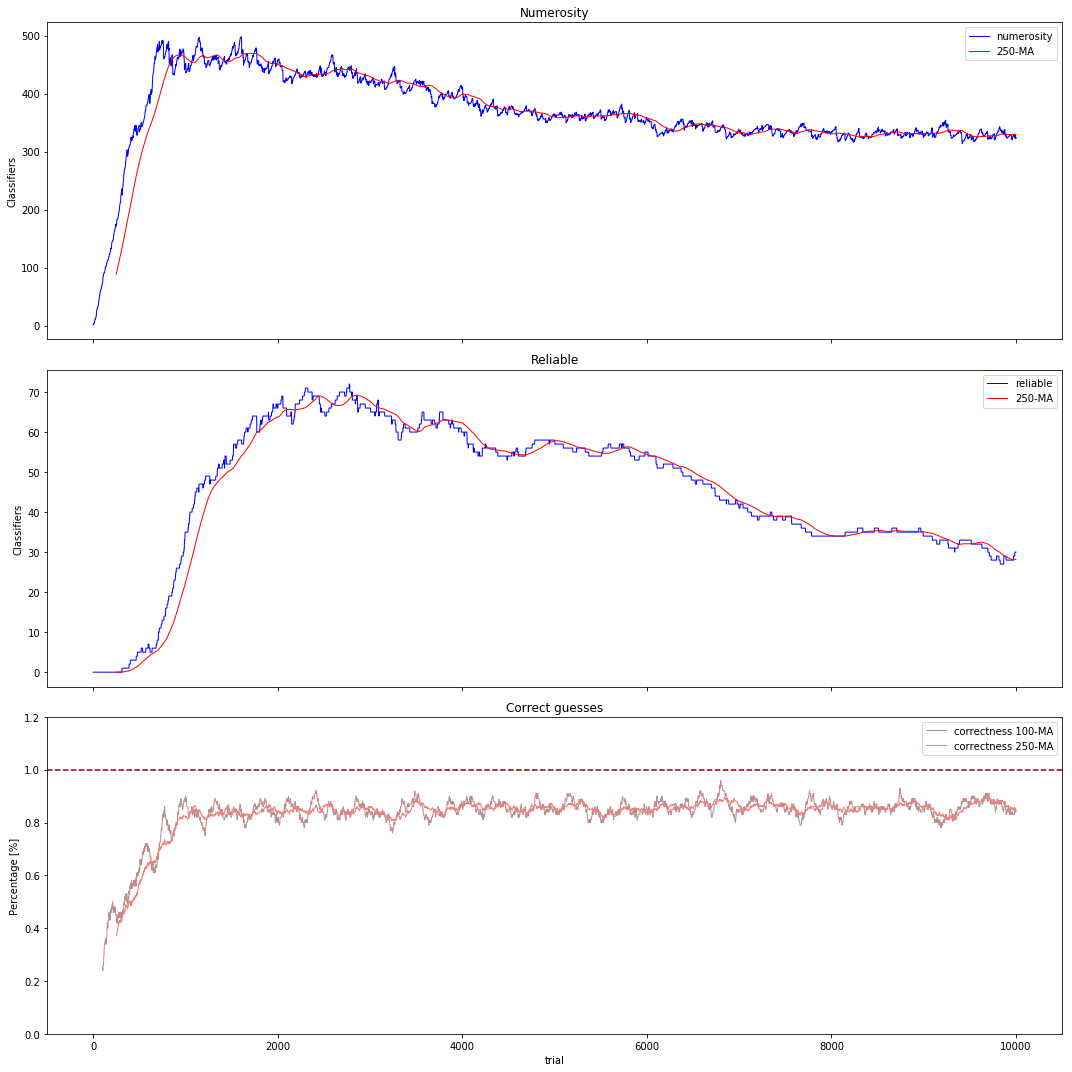

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))

# Numerosity
df['numerosity'].plot(ax=ax1, color='blue', linewidth=1.0, label='numerosity')
df['numerosity'].rolling(window=250).mean().plot(ax=ax1, color='r', linewidth=1.0, label='250-MA')
ax1.set_title('Numerosity')
ax1.set_ylabel('Classifiers')
ax1.legend()

# Reliable
df['reliable'].plot(ax=ax2, color='b', linewidth=1.0, label='reliable')
df['reliable'].rolling(window=250).mean().plot(ax=ax2, color='r', linewidth=1.0, label='250-MA')
ax2.set_title('Reliable')
ax2.set_ylabel('Classifiers')
ax2.legend()

# Obtained performance
df['was_correct'].rolling(window=100).mean().plot(ax=ax3, linewidth=1.0, color='rosybrown', label='correctness 100-MA')
df['was_correct'].rolling(window=250).mean().plot(ax=ax3, linewidth=1.0, color='lightcoral', label='correctness 250-MA')
ax3.axhline(y=1.0, c='darkred', linewidth=1.5, linestyle='dashed')
ax3.set_title('Correct guesses')
ax3.set_ylabel('Percentage [%]')
ax3.set_ylim([0, 1.2])
ax3.legend()

plt.tight_layout()
plt.show()